# Part 3: Modelling of Selected Features for deployment

- In this final notebook, we will be selecting specific features with model deployment being the end goal in mind. A simplified exploratory data analysis, together with necessary data cleaning, data wrangling, data preprocessing and feature engineering will be conducted

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from joblib import dump
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", 60)

## Codebook / Data Dictionary

| Variable | Description |
| -------- | -------- |
| resale_price | the property's sale price in Singapore dollars. This is the target variable that you're trying to predict for this challenge.|
| Tranc_YearMonth | year and month of the resale transaction, e.g. 2015-02 |
| town| HDB township where the flat is located, e.g. BUKIT MERAH |
| flat_type | type of the resale flat unit, e.g. 3 ROOM |
| block | block number of the resale flat, e.g. 454 |
| street_name | street name where the resale flat resides, e.g. TAMPINES ST 42 |
| storey_range | floor level (range) of the resale flat unit, e.g. 07 TO 09 |
| floor_area_sqm | floor area of the resale flat unit in square metres |
| flat_model | HDB model of the resale flat, e.g. Multi Generation |
| lease_commence_date | commencement year of the flat unit's 99-year lease |
| Tranc_Year | year of resale transaction |
| Tranc_Month | month of resale transaction |
| mid_storey | median value of storey_range |
| lower | lower value of storey_range |
| upper | upper value of storey_range |
| mid | middle value of storey_range |
| full_flat_type | combination of flat_type and flat_model |
| address | combination of block and street_name |
| floor_area_sqft | floor area of the resale flat unit in square feet |
| hdb_age | number of years from lease_commence_date to present year |
| max_floor_lvl | highest floor of the resale flat |
| year_completed | year which construction was completed for resale flat |
| residential | boolean value if resale flat has residential units in the same block |
| commercial | boolean value if resale flat has commercial units in the same block |
| market_hawker | boolean value if resale flat has a market or hawker centre in the same block |
| multistorey_carpark| boolean value if resale flat has a multistorey carpark in the same block |
| precinct_pavilion | boolean value if resale flat has a pavilion in the same block |
| total_dwelling_units| total number of residential dwelling units in the resale flat |
| 1room_sold | number of 1-room residential units in the resale flat |
| 2room_sold | number of 2-room residential units in the resale flat |
| 3room_sold | number of 3-room residential units in the resale flat |
| 4room_sold | number of 4-room residential units in the resale flat |
| 5room_sold | number of 5-room residential units in the resale flat |
| exec_sold | number of executive type residential units in the resale flat block |
| multigen_sold | number of multi-generational type residential units in the resale flat block |
| studio_apartment_sold | number of studio apartment type residential units in the resale flat block |
| 1room_rental | number of 1-room rental residential units in the resale flat block |
| 2room_rental | number of 2-room rental residential units in the resale flat block |
| 3room_rental | number of 3-room rental residential units in the resale flat block |
| other_room_rental | number of "other" type rental residential units in the resale flat block |
| postal | postal code of the resale flat block |
| Latitude | Latitude based on postal code |
| Longitude | Longitude based on postal code |
| planning_area | Government planning area that the flat is located |
| Mall_Nearest_Distance | distance (in metres) to the nearest mall |
| Mall_Within_500m | number of malls within 500 metres |
| Mall_Within_1km | number of malls within 1 kilometre |
| Mall_Within_2km | number of malls within 2 kilometres |
| Hawker_Nearest_Distance | distance (in metres) to the nearest hawker centre |
| Hawker_Within_500m | number of hawker centres within 500 metres |
| Hawker_Within_1km | number of hawker centres within 1 kilometre |
| Hawker_Within_2km | number of hawker centres within 2 kilometres |
| hawker_food_stalls | number of hawker food stalls in the nearest hawker centre |
| hawker_market_stalls | number of hawker and market stalls in the nearest hawker centre |
| mrt_nearest_distance | distance (in metres) to the nearest MRT station |
| mrt_name | name of the nearest MRT station |
| bus_interchange | boolean value if the nearest MRT station is also a bus interchange |
| mrt_interchange | boolean value if the nearest MRT station is a train interchange station |
| mrt_latitude | latitude (in decimal degrees) of the the nearest MRT station |
| mrt_longitude | longitude (in decimal degrees) of the nearest MRT station |
| bus_stop_nearest_distance | distance (in metres) to the nearest bus stop |
| bus_stop_name | name of the nearest bus stop |
| bus_stop_latitude | latitude (in decimal degrees) of the the nearest bus stop |
| bus_stop_longitude| longitude (in decimal degrees) of the nearest bus stop |
| pri_sch_nearest_distance | distance (in metres) to the nearest primary school |
| pri_sch_name | name of the nearest primary school |
| vacancy | number of vacancies in the nearest primary school |
| pri_sch_affiliation | boolean value if the nearest primary school has a secondary school affiliation |
| pri_sch_latitude | latitude (in decimal degrees) of the the nearest primary school |
| pri_sch_longitude | longitude (in decimal degrees) of the nearest primary school |
| sec_sch_nearest_dist | distance (in metres) to the nearest secondary school |
| sec_sch_name | name of the nearest secondary school |
| cutoff_point | PSLE cutoff point of the nearest secondary school |
| affiliation | boolean value if the nearest secondary school has an primary school affiliation |
| sec_sch_latitude | latitude (in decimal degrees) of the the nearest secondary school |
| sec_sch_longitude | longitude (in decimal degrees) of the nearest secondary school |

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", 200)

In [3]:
hdb = pd.read_csv('../datasets/train.csv')
hdb.shape

(150634, 78)

## Imputation of Null Values

In [4]:
null_pct = hdb.isnull().sum() / len(hdb) * 100
null_pct.sort_values(ascending=False).head(10)

Hawker_Within_500m         64.653398
Mall_Within_500m           61.598975
Hawker_Within_1km          40.407876
Hawker_Within_2km          19.386062
Mall_Within_1km            16.879323
Mall_Within_2km             1.287890
Mall_Nearest_Distance       0.550341
Hawker_Nearest_Distance     0.000000
mrt_nearest_distance        0.000000
hawker_market_stalls        0.000000
dtype: float64

In [5]:
#Drop NA values in Mall_Nearest_Distance as it accounts for <5% of total data
hdb.dropna(subset=['Mall_Nearest_Distance', 'Mall_Within_2km'], inplace=True)

In [6]:
hdb[hdb['Hawker_Within_2km'].isnull()][['Hawker_Nearest_Distance', 'Hawker_Within_2km']].sort_values(by = 'Hawker_Nearest_Distance', ascending=True).head(5)

,Hawker_Nearest_Distance,Hawker_Within_2km
43430,2000.871907,NaN
115901,2000.871907,NaN
90915,2000.871907,NaN
91533,2000.871907,NaN
8001,2000.871907,NaN


In [7]:
hdb[hdb['Hawker_Within_500m'].isnull()][['Hawker_Nearest_Distance', 'Hawker_Within_500m']].sort_values(by='Hawker_Nearest_Distance', ascending=True).head(5)

,Hawker_Nearest_Distance,Hawker_Within_500m
59745,500.208726,NaN
23788,500.208726,NaN
111167,500.208726,NaN
134788,500.208726,NaN
8264,500.208726,NaN


In [8]:
hdb[hdb['Hawker_Within_1km'].isnull()][['Hawker_Nearest_Distance', 'Hawker_Within_1km']].sort_values(by='Hawker_Nearest_Distance', ascending=True).head(5)

,Hawker_Nearest_Distance,Hawker_Within_1km
60077,1000.216189,NaN
130417,1000.216189,NaN
114661,1000.216189,NaN
59523,1000.216189,NaN
7055,1000.216189,NaN


In [9]:
hdb[hdb['Hawker_Within_2km'].isnull()][['Hawker_Nearest_Distance', 'Hawker_Within_2km']].sort_values(by = 'Hawker_Nearest_Distance', ascending=True).head(5)

,Hawker_Nearest_Distance,Hawker_Within_2km
43430,2000.871907,NaN
115901,2000.871907,NaN
90915,2000.871907,NaN
91533,2000.871907,NaN
8001,2000.871907,NaN


In [10]:
#Impute zeroes to all hawker centers/malls radial threshold distance with missing values based on our above analysis
hdb['Hawker_Within_500m'] = hdb['Hawker_Within_500m'].fillna(0.0)
hdb['Hawker_Within_1km'] = hdb['Hawker_Within_1km'].fillna(0.0)
hdb['Hawker_Within_2km'] = hdb['Hawker_Within_2km'].fillna(0.0)
hdb['Mall_Within_1km'] = hdb['Mall_Within_1km'].fillna(0.0)
hdb['Mall_Within_500m'] = hdb['Mall_Within_500m'].fillna(0.0)

In [11]:
def subplot_cat(df, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)))
    fig, ax = plt.subplots(nrows=nrows, ncols=2, sharex=False, sharey=False, squeeze=True, figsize=(10,30))
    ax = ax.ravel()
    for i, column in enumerate(list_of_columns):
        sns.boxplot(data = df, y = "resale_price",x = column , ax = ax[2*i])
        sns.countplot(data = df, x = column, ax = ax[2*i+1])
        ax[i].set_title(f'{column} vs HDB resale price')
    plt.tight_layout()

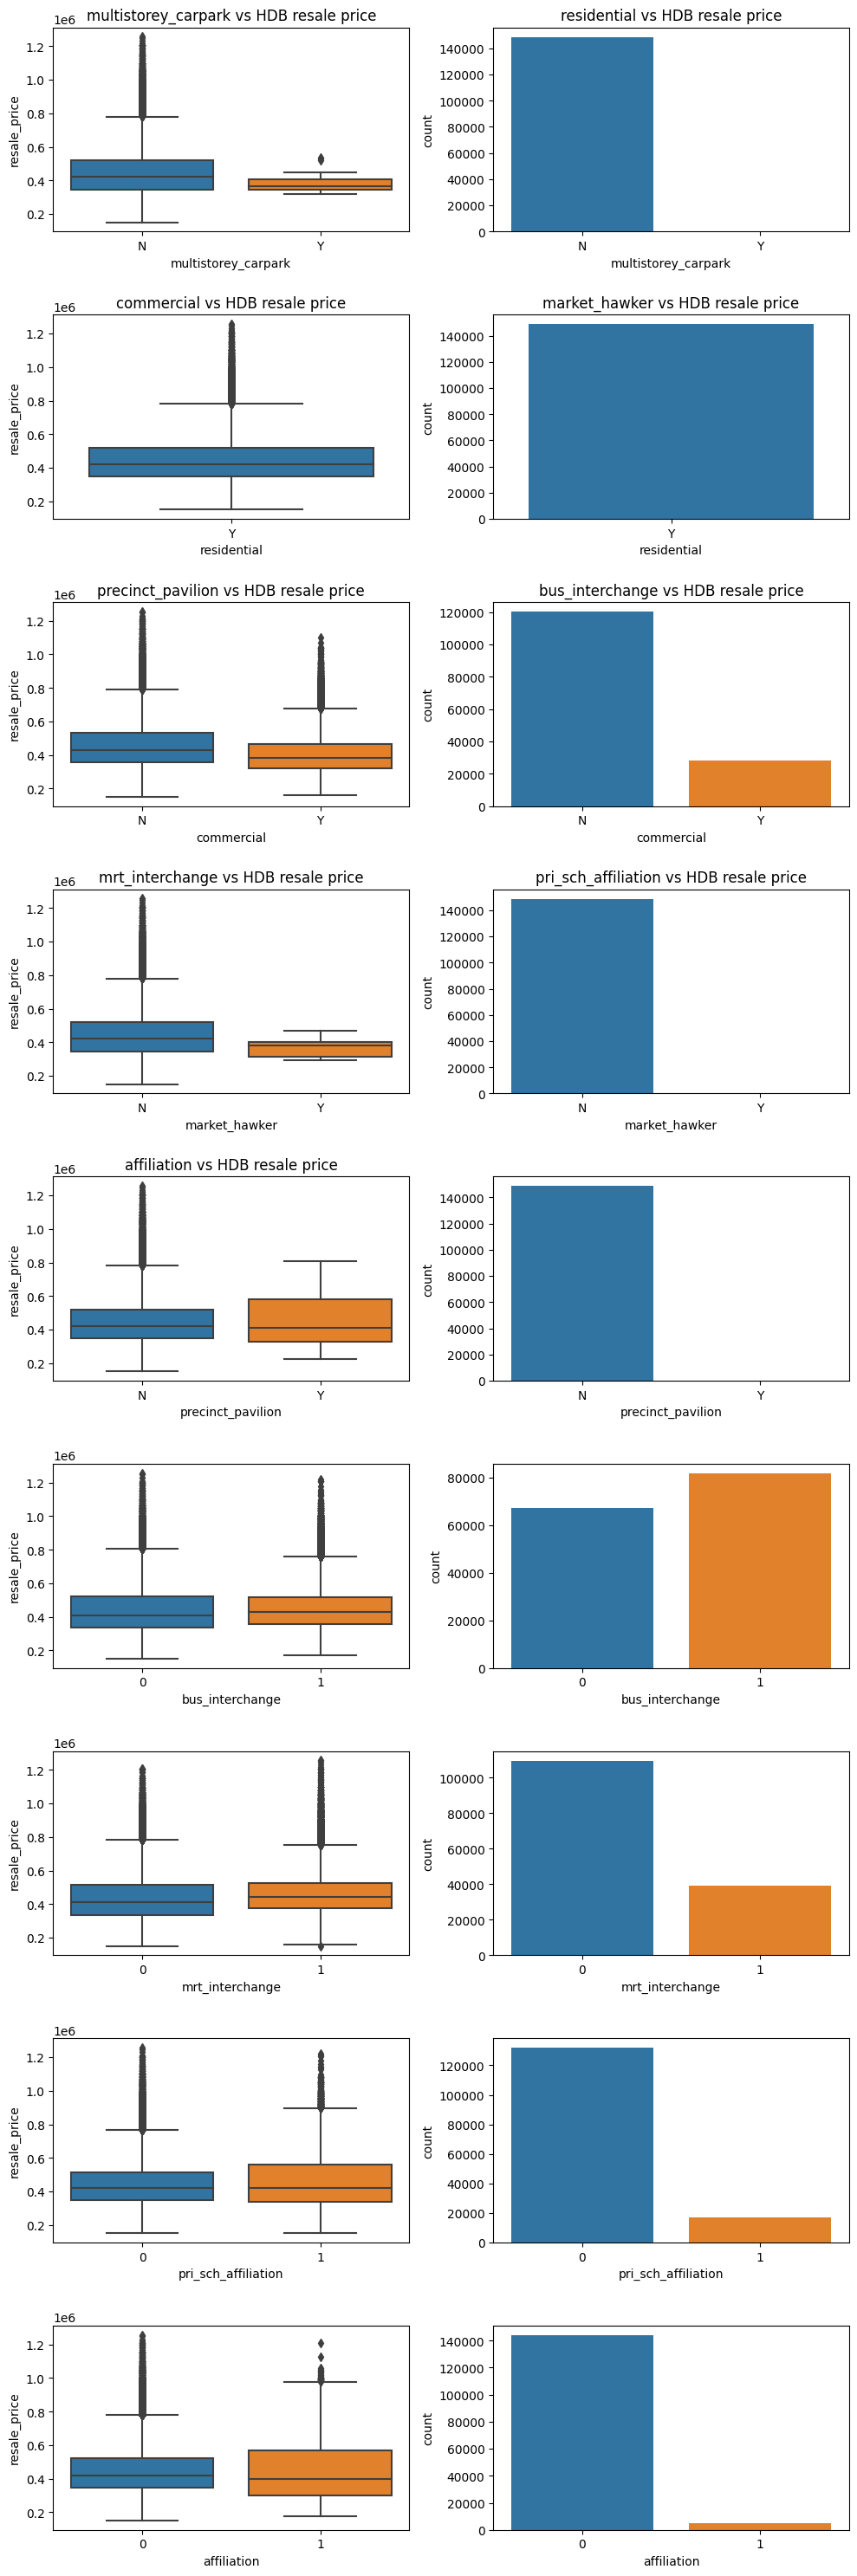

In [12]:
subplot_cat(hdb, ["multistorey_carpark","residential","commercial","market_hawker", "precinct_pavilion", "bus_interchange", "mrt_interchange", "pri_sch_affiliation", "affiliation"])

We can see that there is no significant differences in the impact towards HDB resale price for these boolean related features

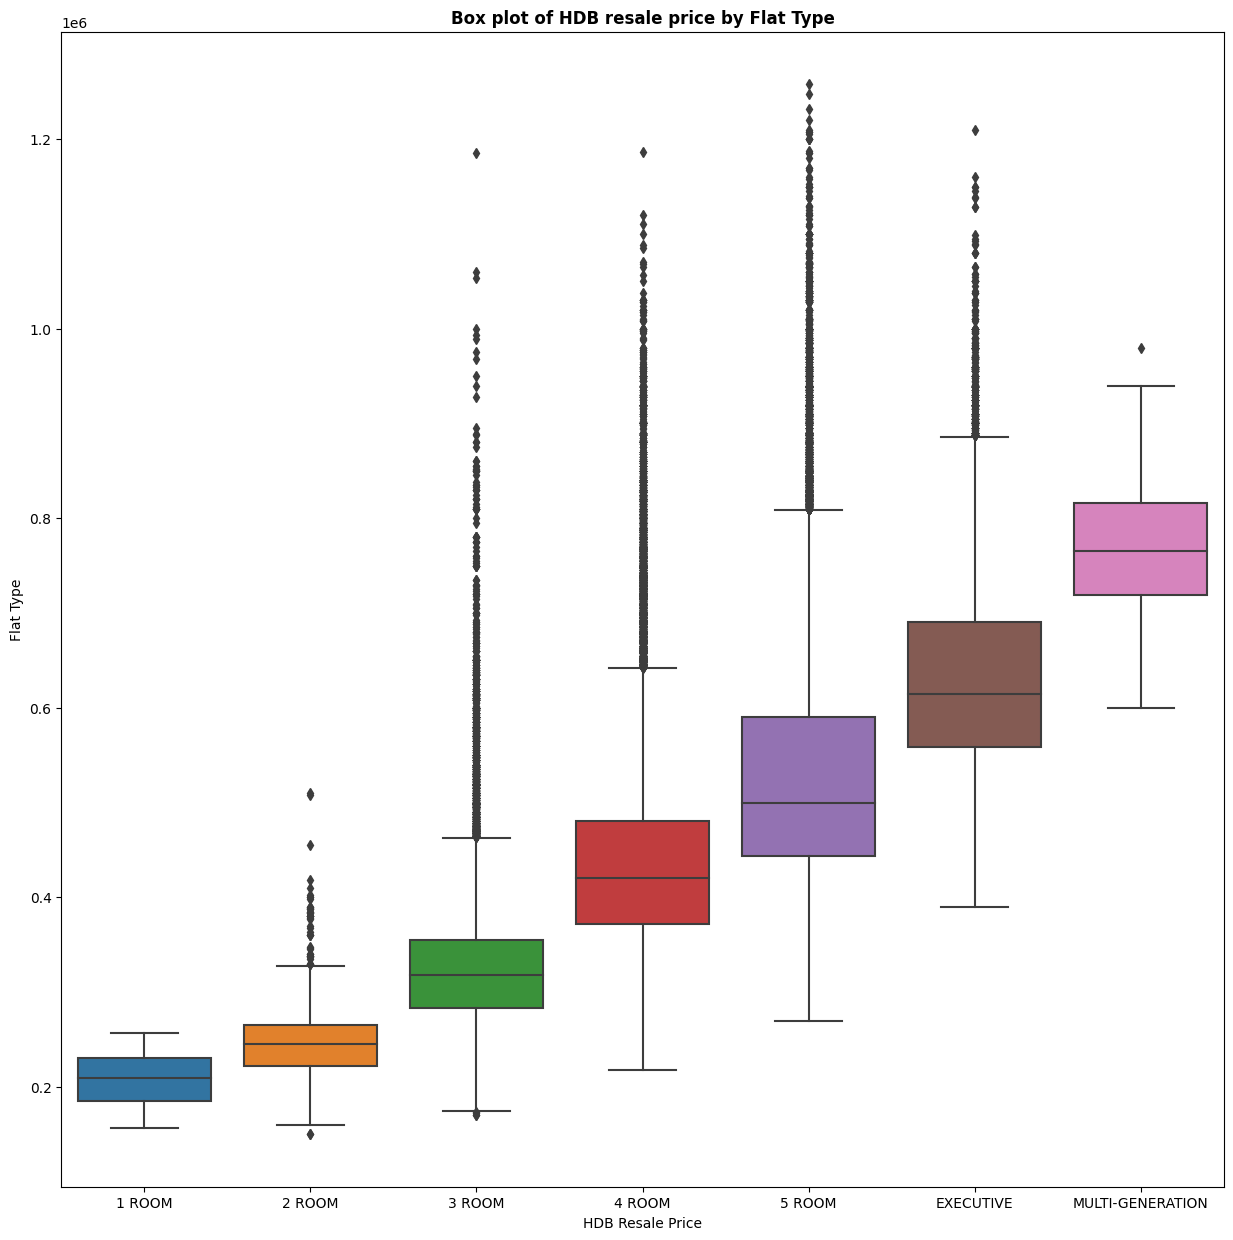

In [13]:
plt.figure(figsize=(15, 15))
sns.boxplot(data=hdb, y='resale_price', x='flat_type', order=['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION'])
#sns.set(font_scale=2)
plt.title('Box plot of HDB resale price by Flat Type', fontweight='bold')
plt.ylabel('Flat Type')
plt.xlabel('HDB Resale Price');

It is observed that the resale price increases for units with more rooms indicating more spacious units. However, there are considerable amount of outliers across the different HDB flat types

In [14]:
hdb.groupby('flat_type')['resale_price'].describe().round(4)

,count,mean,std,min,25%,50%,75%,max
flat_type,,,,,,,,
1 ROOM,82.0,207015.4634,25312.3276,157000.0,185000.0,209000.0,230000.0,257000.0
2 ROOM,1887.0,245532.2485,35694.9687,150000.0,222000.0,245000.0,265000.0,510000.0
3 ROOM,38693.0,326433.2077,67515.3359,170000.0,283000.0,318000.0,355000.0,1185000.0
4 ROOM,60115.0,444470.5113,109820.8330,218000.0,372000.0,420000.0,480000.0,1186888.0
5 ROOM,35993.0,536886.6874,135357.8688,270000.0,444000.0,500000.0,590000.0,1258000.0
EXECUTIVE,11868.0,633815.6307,108916.6674,390000.0,558888.0,615000.0,690000.0,1210000.0
MULTI-GENERATION,56.0,767992.0000,77867.9851,600000.0,719500.0,765500.0,815750.0,980000.0


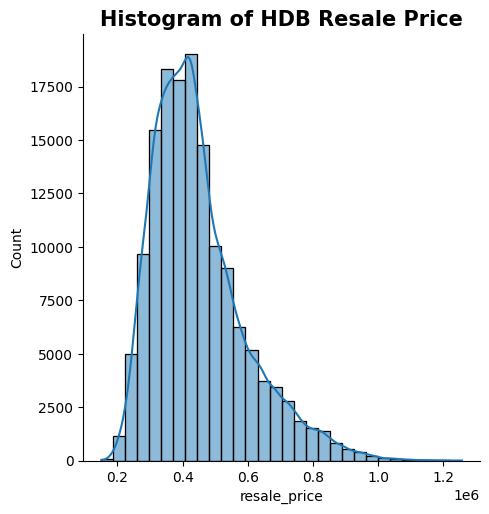

In [15]:
sns.displot(hdb['resale_price'], bins=30, kde=True);
plt.title('Histogram of HDB Resale Price', fontsize=15, fontweight='bold');
plt.show();

Observed that the distribution of resale price data is right skewed towards being more expensive, this indicates that outliers are present. We will use the 3 sigma statistical criteria to examine the root cause behind these outliers

In [16]:
#Using upper bound of 3 sigma criteria to narrow down the outliers
mean = np.mean(hdb['resale_price'])
std = np.std(hdb['resale_price'])
threshold = 3 * std
outliers = hdb[hdb['resale_price'] > (mean + threshold)]

In [17]:
outliers['flat_type'].value_counts()

5 ROOM              1052
EXECUTIVE            406
4 ROOM               255
3 ROOM                16
MULTI-GENERATION       4
Name: flat_type, dtype: int64

In [18]:
outliers['town'].value_counts()

CENTRAL AREA       279
QUEENSTOWN         264
TOA PAYOH          229
BISHAN             225
BUKIT MERAH        217
KALLANG/WHAMPOA    116
BUKIT TIMAH         91
CLEMENTI            88
ANG MO KIO          56
GEYLANG             49
SERANGOON           48
MARINE PARADE       35
BEDOK               11
HOUGANG              8
PUNGGOL              5
CHOA CHU KANG        4
BUKIT BATOK          3
TAMPINES             3
JURONG EAST          2
Name: town, dtype: int64

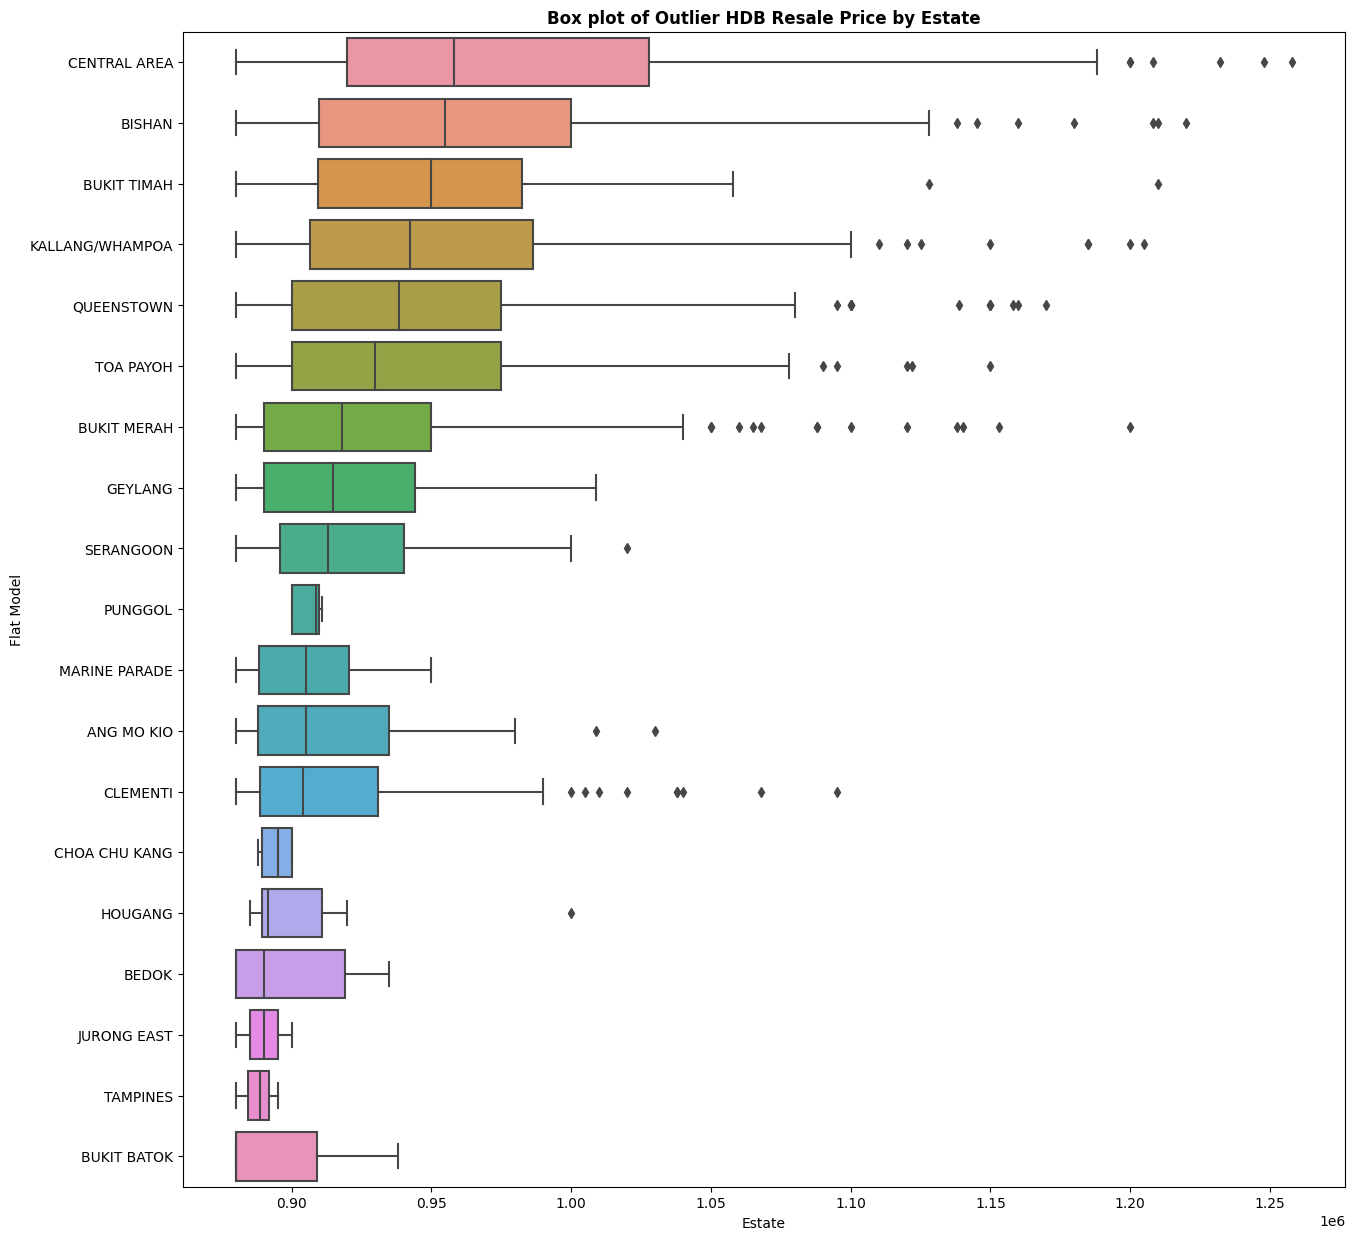

In [19]:
plt.figure(figsize=(15, 15))
order = outliers.groupby('town')[['resale_price']].median().sort_values(by='resale_price', ascending=False).index
sns.boxplot(data=outliers, x='resale_price', y='town', order=order, orient='h');
plt.title('Box plot of Outlier HDB Resale Price by Estate', fontweight='bold')
plt.ylabel('Flat Model')
plt.xlabel('Estate');
plt.show()

Based on the box plot distribution and the total outlier counts for each town, we can infer that most of the HDB resale flats having abnormally high prices are located in mature estates that have been present for at least 20 years with good connectivity and amenities: https://www.99.co/singapore/insider/what-is-non-mature-estates-vs-mature-estates-hdb/ 

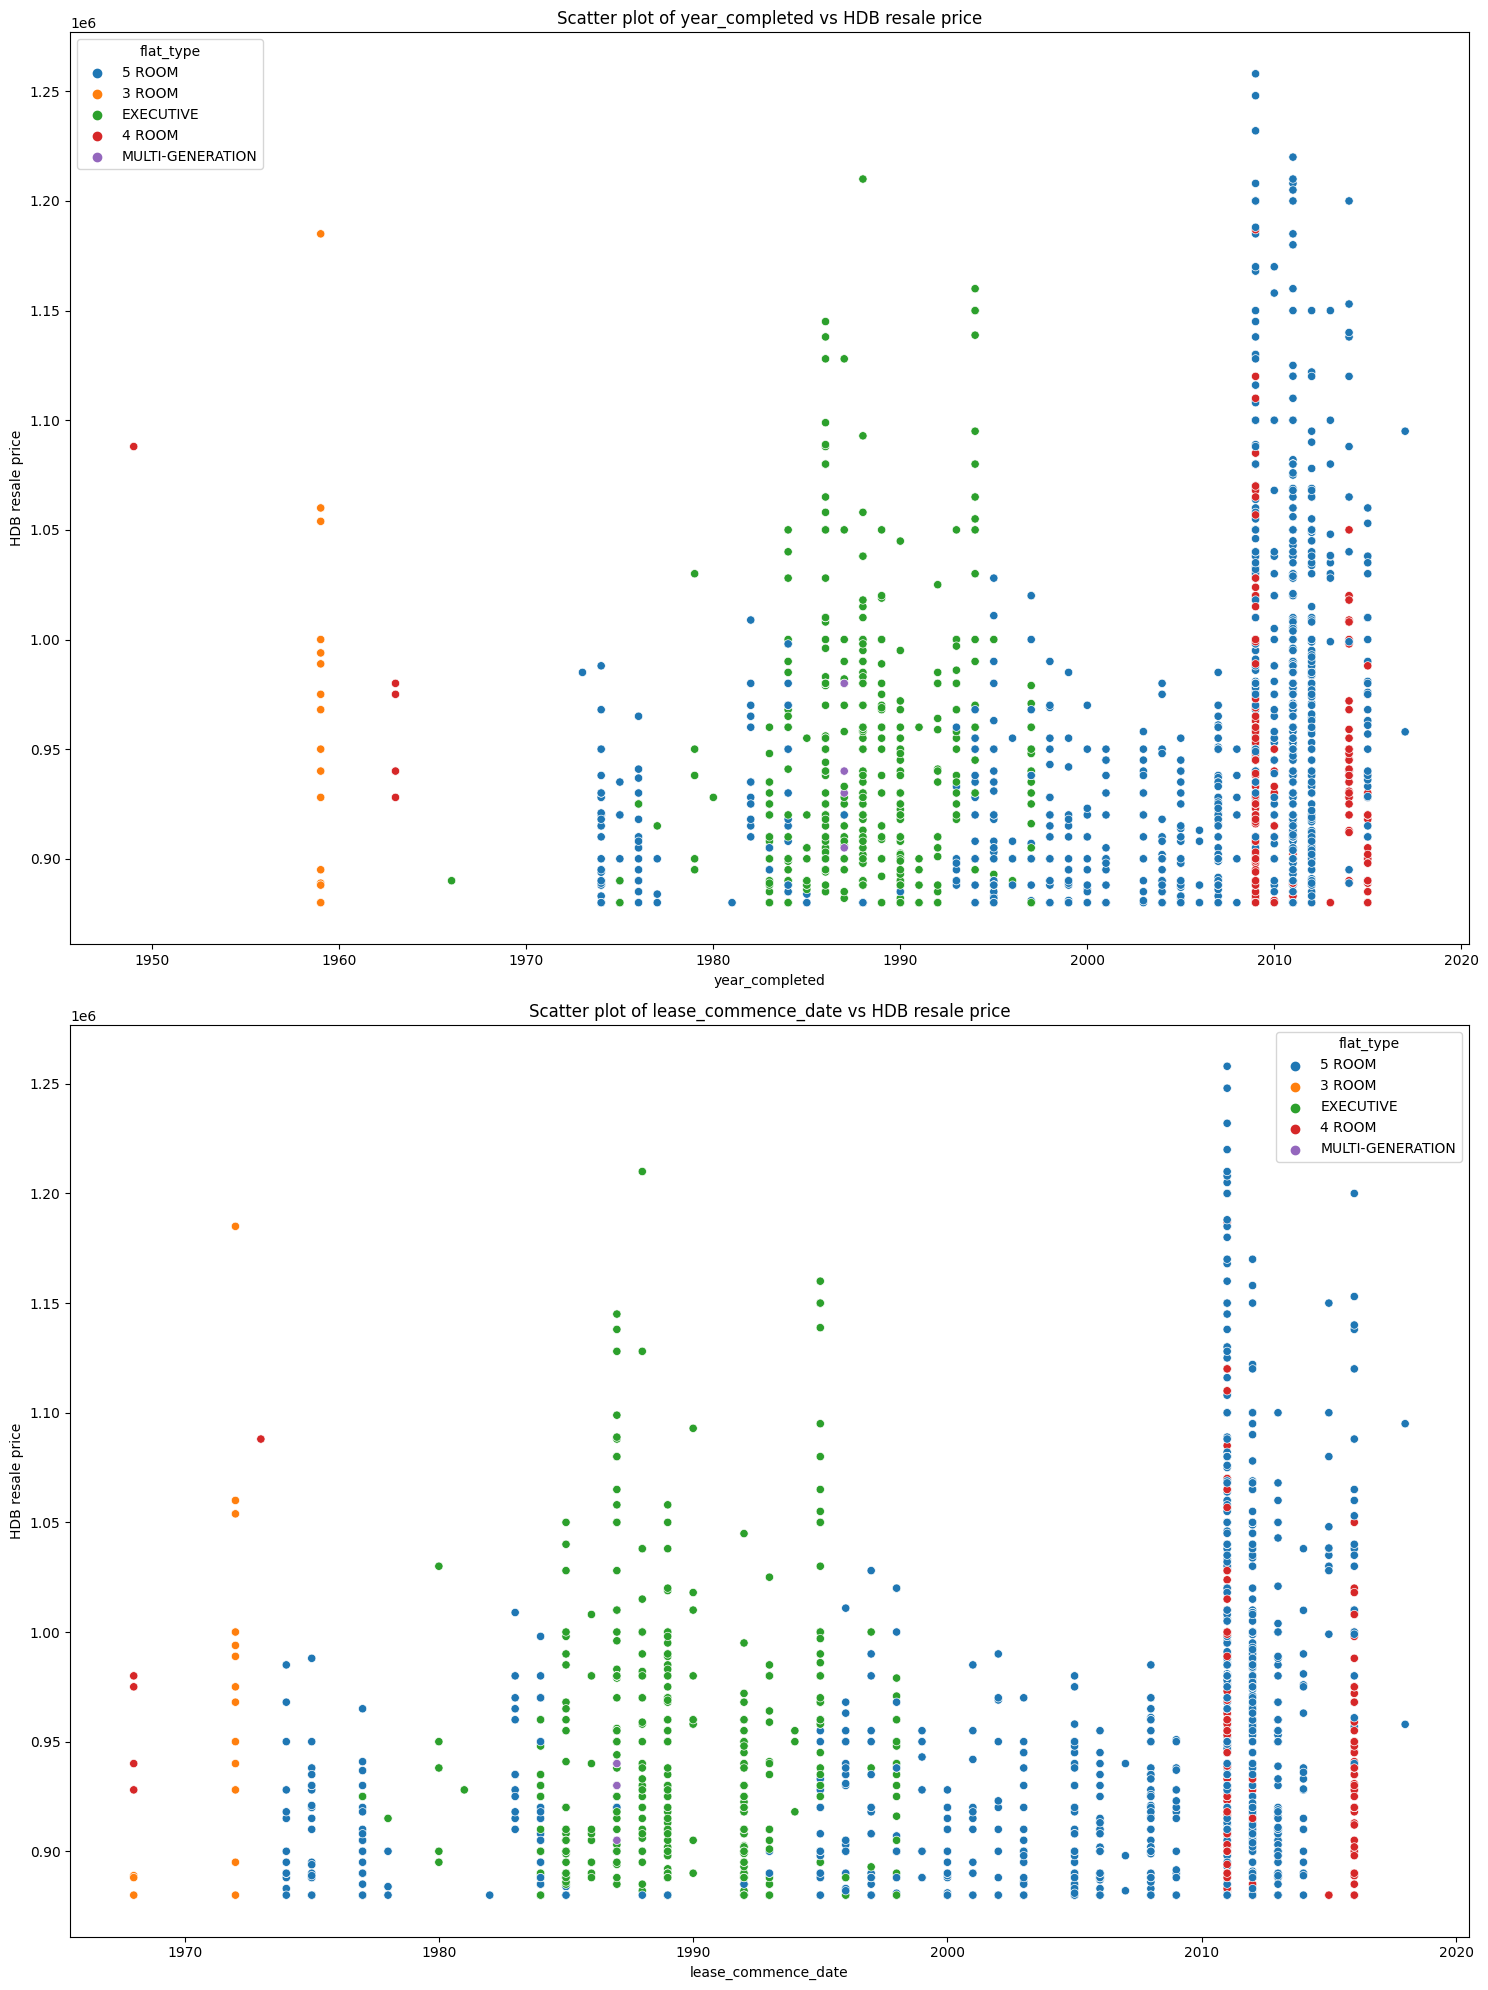

In [20]:
#Initialise 3x1 subplot grid
fig, ax = plt.subplots(2, 1, figsize=(15, 20)) 
#for loop to iterate given list of possbile features, plot the respective scatter plots
for i, x in enumerate(['year_completed', 'lease_commence_date']):
    row = i // 2
    col = i % 2
    sns.scatterplot(x=x, y='resale_price', data=outliers, ax=ax[i], hue='flat_type')
    ax[i].set_title(f'Scatter plot of {x} vs HDB resale price')
    ax[i].set_ylabel('HDB resale price')
    ax[i].set_xlabel(f'{x}')

plt.tight_layout()
plt.show()

-From the above 2 visuals, we can infer that most of the expensive HDB resale units during the 1980s - 1990s were coming from executive units due to their popularity from having larger housing space as compared to 4/5 room flats.

-After 2010, the prices of resale flats begin to increase substantially where many new 4/5 room units are being sold at 900k and higher. This could be partly attributed to several factors such as changes in housing policies, low interest rates of flat units, and higher demand for them during the period

-As many of these outlier points are coming from the newer HDB units that were constructed during the 2010s, it is not feasible to discard them during modelling since they could influence the overall HDB resale price in the property market. Hence, we will not filter them out in our dataset

## Feature Engineering and Selection

-We will proceed for the feature selection of numerical features having colinearity of r > |0.1| w.r.t resale price based on the pearson correlation coeficient value

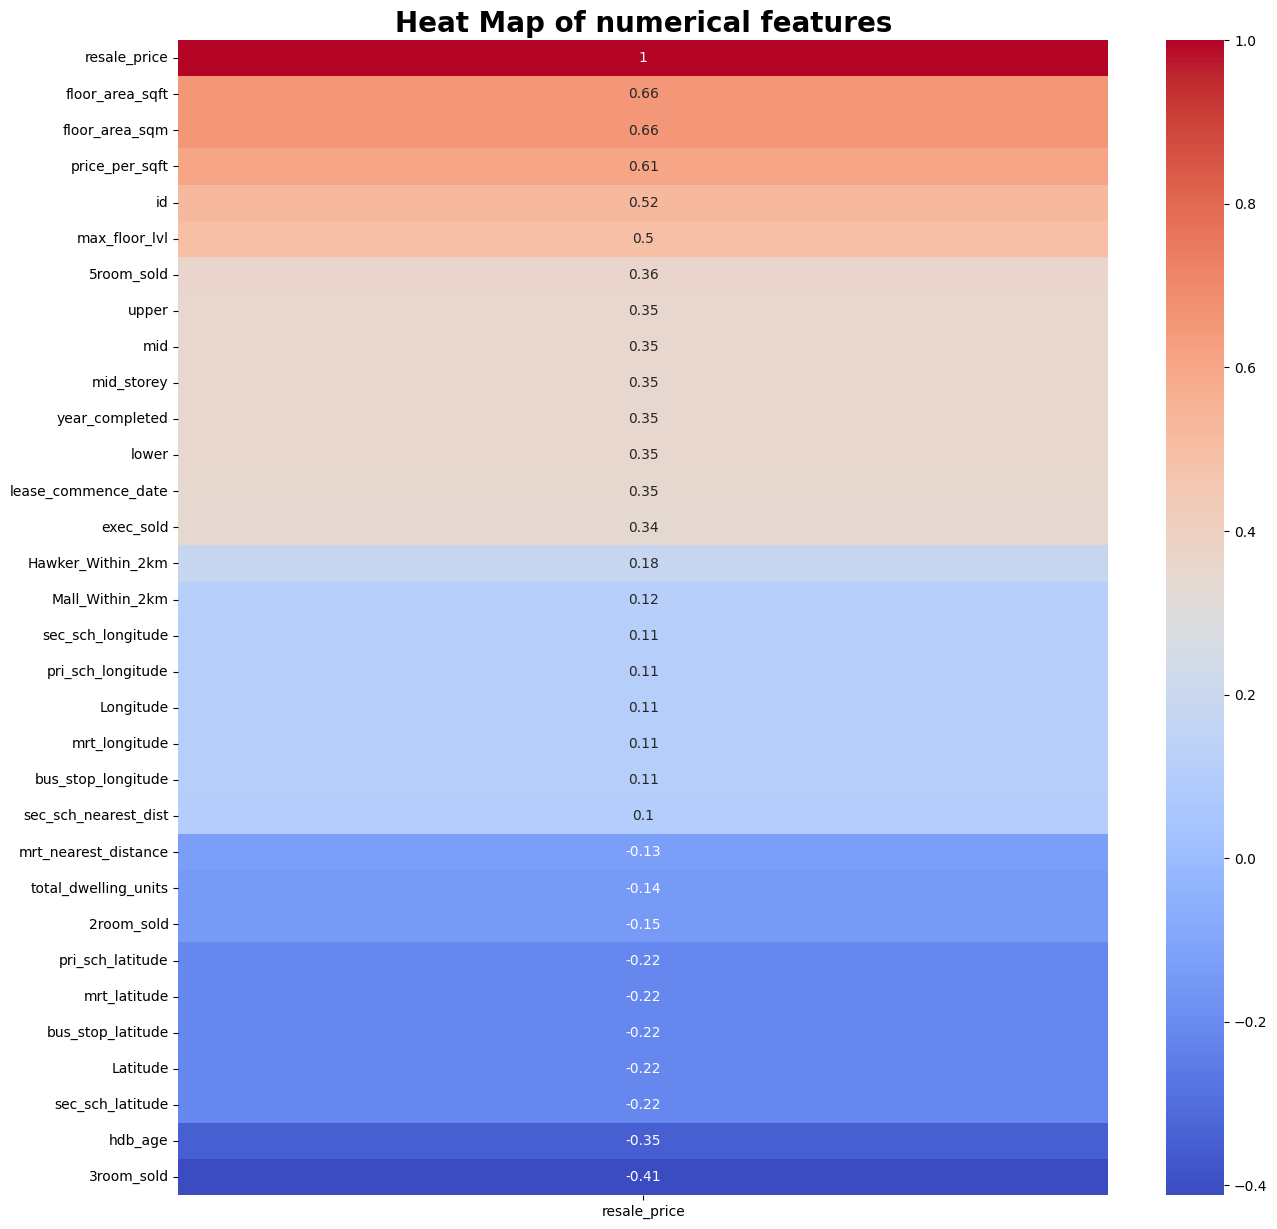

In [21]:
corr = hdb.corr()[['resale_price']]
corr_0_1 = corr[(corr['resale_price'] >= 0.1) | (corr['resale_price'] <= -0.1)].sort_values(by='resale_price', ascending=False)
plt.figure(figsize=(15, 15))
sns.reset_defaults()
sns.heatmap(corr_0_1, annot=True, cmap='coolwarm')
plt.title('Heat Map of numerical features',size=20, fontweight="bold")
plt.show()

In [22]:
corr_0_1.index

Index(['resale_price', 'floor_area_sqft', 'floor_area_sqm', 'price_per_sqft',
       'id', 'max_floor_lvl', '5room_sold', 'upper', 'mid', 'mid_storey',
       'year_completed', 'lower', 'lease_commence_date', 'exec_sold',
       'Hawker_Within_2km', 'Mall_Within_2km', 'sec_sch_longitude',
       'pri_sch_longitude', 'Longitude', 'mrt_longitude', 'bus_stop_longitude',
       'sec_sch_nearest_dist', 'mrt_nearest_distance', 'total_dwelling_units',
       '2room_sold', 'pri_sch_latitude', 'mrt_latitude', 'bus_stop_latitude',
       'Latitude', 'sec_sch_latitude', 'hdb_age', '3room_sold'],
      dtype='object')

In [23]:
new_hdb = hdb[list(corr_0_1.index) + ['town', 'flat_type', 'flat_model', 'Tranc_Year']]

In [24]:
new_hdb.columns

Index(['resale_price', 'floor_area_sqft', 'floor_area_sqm', 'price_per_sqft',
       'id', 'max_floor_lvl', '5room_sold', 'upper', 'mid', 'mid_storey',
       'year_completed', 'lower', 'lease_commence_date', 'exec_sold',
       'Hawker_Within_2km', 'Mall_Within_2km', 'sec_sch_longitude',
       'pri_sch_longitude', 'Longitude', 'mrt_longitude', 'bus_stop_longitude',
       'sec_sch_nearest_dist', 'mrt_nearest_distance', 'total_dwelling_units',
       '2room_sold', 'pri_sch_latitude', 'mrt_latitude', 'bus_stop_latitude',
       'Latitude', 'sec_sch_latitude', 'hdb_age', '3room_sold', 'town',
       'flat_type', 'flat_model', 'Tranc_Year'],
      dtype='object')

In [25]:
#drop similar columns that represent the same feature in context, and redundant ones
new_hdb.drop(columns=['id', 'floor_area_sqft', 'mid_storey', 'price_per_sqft'], inplace=True)

In [26]:
new_hdb.columns, new_hdb.shape

(Index(['resale_price', 'floor_area_sqm', 'max_floor_lvl', '5room_sold',
        'upper', 'mid', 'year_completed', 'lower', 'lease_commence_date',
        'exec_sold', 'Hawker_Within_2km', 'Mall_Within_2km',
        'sec_sch_longitude', 'pri_sch_longitude', 'Longitude', 'mrt_longitude',
        'bus_stop_longitude', 'sec_sch_nearest_dist', 'mrt_nearest_distance',
        'total_dwelling_units', '2room_sold', 'pri_sch_latitude',
        'mrt_latitude', 'bus_stop_latitude', 'Latitude', 'sec_sch_latitude',
        'hdb_age', '3room_sold', 'town', 'flat_type', 'flat_model',
        'Tranc_Year'],
       dtype='object'),
 (148694, 32))

In [27]:
#custom function to map the different towns based on whether they are mature estates or not
town_list = ['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH', 'CENTRAL AREA', 'CLEMENTI', 
                 'GEYLANG', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'QUEENSTOWN', 'SERANGOON', 
                 'TAMPINES', 'TOA PAYOH']
new_hdb['Mature_Estate'] = new_hdb['town'].apply(lambda x: 1 if x in town_list else 0)

In [28]:
#Create new features from existing variables to improve the modelling process(feature description as below):
#remaining_lease: Number of remaining lease years of the flat
new_hdb['remaining_lease'] = new_hdb['lease_commence_date'] + 99 - new_hdb['Tranc_Year']

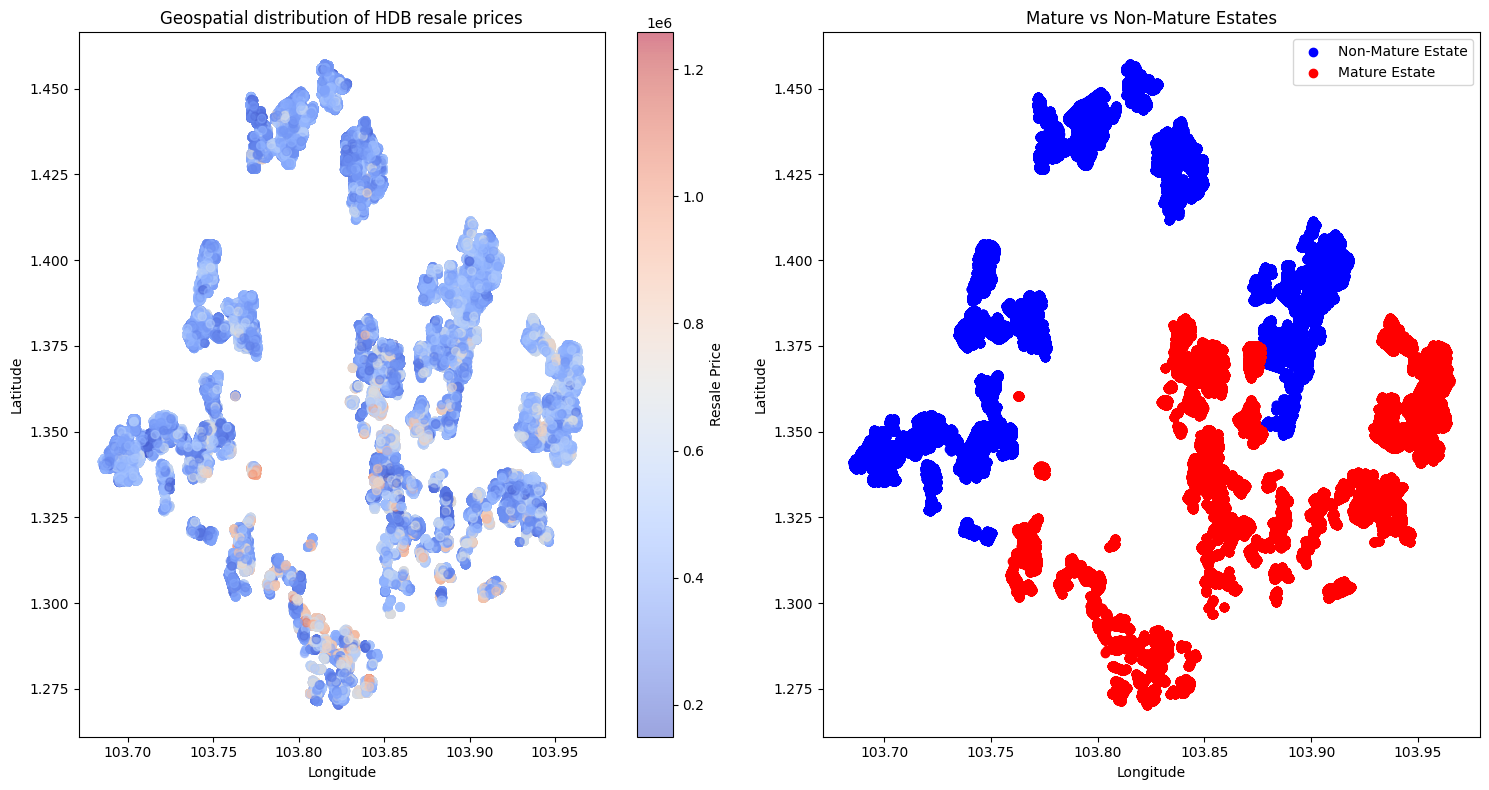

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Plot 1: Resale Price distribution
scatter1 = ax1.scatter(x=new_hdb['Longitude'], y=new_hdb['Latitude'], c=new_hdb['resale_price'], cmap='coolwarm', alpha=0.5)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Geospatial distribution of HDB resale prices')
fig.colorbar(scatter1, ax=ax1, label='Resale Price')

# Plot 2: Mature vs Non-mature estates
scatter2 = ax2.scatter(x=new_hdb.loc[new_hdb['Mature_Estate'] == 0, 'Longitude'], y=new_hdb.loc[new_hdb['Mature_Estate'] == 0, 'Latitude'],
                       c='blue', label='Non-Mature Estate')
scatter3 = ax2.scatter(x=new_hdb.loc[new_hdb['Mature_Estate'] == 1, 'Longitude'], y=new_hdb.loc[new_hdb['Mature_Estate'] == 1, 'Latitude'],
                       c='red', label='Mature Estate')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Mature vs Non-Mature Estates')
ax2.legend()

plt.tight_layout()
plt.show()

HDB resale flats located in town areas classified as mature estates are generally known to be sold at a much higher price

We will select the final features to be passed in for modelling and eventual deployment to production as the end goal of the project

In [30]:
#Select final features for modelling
final_hdb = new_hdb[['remaining_lease', 'Mature_Estate', 'max_floor_lvl', 'floor_area_sqm', 'mid', 'town', 'flat_type', 'resale_price', 'mrt_nearest_distance']]

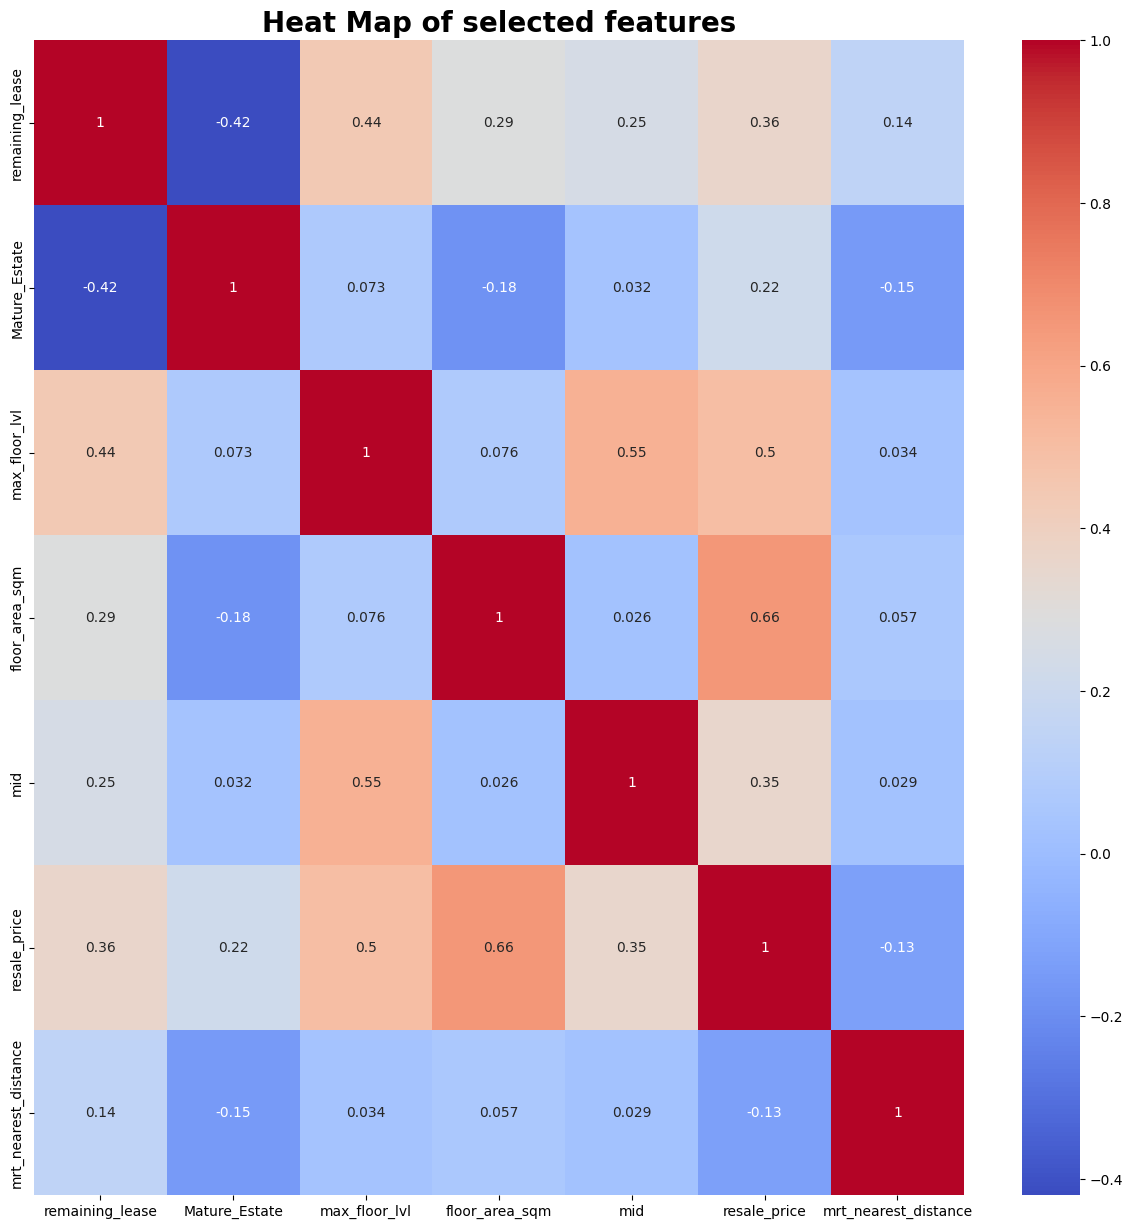

In [31]:
plt.figure(figsize=(15, 15))
sns.heatmap(final_hdb.corr(), annot=True, cmap='coolwarm')
plt.title('Heat Map of selected features',size=20, fontweight="bold")
plt.show()

-From the final set of selected features, none of the features have multicolinearity > 0.7 as evidenced by the heatmap

## Data Modelling

In [32]:
#Split the dataset into features(X) and target variable(y) for predictions
X = final_hdb.drop(columns=['resale_price'])
y = final_hdb['resale_price']

In [33]:
#Generate custom transformer containing preprocessing libraries: StandardScaler, OneHotEncoder
col_transformer = ColumnTransformer(transformers=[('pt', StandardScaler(),  
                                                   X.drop(columns=['flat_type', 'town']).columns.tolist()), 
                                                  ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ['flat_type', 'town'])], 
                                                  remainder='passthrough', n_jobs=-1)

In [34]:
#Split the dataset into train and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Baseline: Linear Regression

In [35]:
#create pipeline containing all preprocessing/tranformations to fit the model
pipeline0 = Pipeline([
    ('scl', col_transformer),  # Call in custom column transformer
    ('lr', LinearRegression())  # Perform linear regression
])

In [36]:
#cross validation for RMSE
lr_rmse = cross_val_score(pipeline0, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
# Print the CV scores for each fold
for fold, score in enumerate(lr_rmse, start=1):
    print(f"Fold {fold}: {np.abs(score)}")

# Print the mean RMSE
print(f"Mean RMSE: {np.abs(lr_rmse).mean()}")

Fold 1: 53015.018680783796
Fold 2: 53944.53029127193
Fold 3: 54079.75576626299
Fold 4: 54390.69839305381
Fold 5: 54095.17430240913
Mean RMSE: 53905.03548675634


In [37]:
pipeline0.fit(X_train, y_train)

Pipeline(steps=[('scl',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('pt', StandardScaler(),
                                                  ['remaining_lease',
                                                   'Mature_Estate',
                                                   'max_floor_lvl',
                                                   'floor_area_sqm', 'mid',
                                                   'mrt_nearest_distance']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['flat_type', 'town'])])),
                ('lr', LinearRegression())])

In [38]:
#RMSE of Linear regression predict on test set
lr_pred = pipeline0.predict(X_test)
mean_squared_error(y_test, lr_pred, squared=False)

53889.246397223375

In [39]:
#Get the coefficients for each feature in the model
pd.Series(pipeline0.named_steps['lr'].coef_, 
          index=pipeline0[:-1].get_feature_names_out()).sort_values(ascending=False)

ohe__town_MARINE PARADE            191778.151457
ohe__town_BUKIT TIMAH              157949.334824
ohe__flat_type_MULTI-GENERATION    143872.578735
pt__floor_area_sqm                  88837.530714
ohe__town_BISHAN                    83180.153927
ohe__town_CENTRAL AREA              81007.706886
ohe__flat_type_EXECUTIVE            73040.732598
ohe__town_BUKIT MERAH               67205.930899
ohe__town_QUEENSTOWN                59520.018632
pt__Mature_Estate                   57916.142707
ohe__town_JURONG EAST               56312.400766
ohe__town_HOUGANG                   53112.467503
pt__remaining_lease                 47578.203146
ohe__town_CLEMENTI                  30754.471307
ohe__flat_type_5 ROOM               29950.394369
ohe__town_BUKIT BATOK               29408.405526
ohe__town_YISHUN                    25576.636284
ohe__town_KALLANG/WHAMPOA           24248.208241
ohe__flat_type_4 ROOM               20821.216093
pt__max_floor_lvl                   20651.734361
pt__mid             

### Lasso Regularization

In [40]:
pipeline1 = Pipeline([
    ('scl', col_transformer),  # Standardize the features
    ('lasso', LassoCV())  # Perform lasso regression
])

In [41]:
pipe_params = {"lasso__n_alphas": [0, 200, 300, 500]}

In [42]:
gs_lasso = GridSearchCV(pipeline1, param_grid=pipe_params, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
gs_lasso.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('pt',
                                                                         StandardScaler(),
                                                                         ['remaining_lease',
                                                                          'Mature_Estate',
                                                                          'max_floor_lvl',
                                                                          'floor_area_sqm',
                                                                          'mid',
                                                                          'mrt_nearest_distance']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['flat_type',
                                                                          'town'])])),
                                       ('lasso', LassoCV())]),
             n_jobs=-1, param_grid={'lasso__n_alphas': [0, 200, 300, 500]},
             scoring='neg_root_mean_squared_error')

In [43]:
gs_lasso.best_params_

{'lasso__n_alphas': 200}

In [44]:
print(f'best score through grid search: {np.abs(gs_lasso.best_score_)}')

best score through grid search: 54149.16493931968


In [45]:
print(f'RMSE score from train: {np.abs(gs_lasso.score(X_train, y_train))}')
print(f'RMSE score from testing: {np.abs(gs_lasso.score(X_test, y_test))}')

RMSE score from train: 54125.49072929358
RMSE score from testing: 54189.133794075235


In [46]:
model_pred = gs_lasso.predict(X_test)
mean_squared_error(y_test, model_pred, squared=False)

54189.133794075235

In [47]:
gs_lasso.best_estimator_.named_steps['lasso'].alpha_

94.20400693465498

In [48]:
pd.Series(gs_lasso.best_estimator_.named_steps['lasso'].coef_, 
          index=pipeline1[:-1].get_feature_names_out()).sort_values(ascending=False)

ohe__town_MARINE PARADE            164607.329998
ohe__town_BUKIT TIMAH              107325.425633
pt__floor_area_sqm                  94388.864885
ohe__town_BISHAN                    66943.039857
pt__Mature_Estate                   64701.903504
ohe__town_CENTRAL AREA              55747.150616
ohe__town_HOUGANG                   54457.005961
ohe__town_JURONG EAST               54080.148771
ohe__town_BUKIT MERAH               52212.174205
pt__remaining_lease                 46415.349889
ohe__town_QUEENSTOWN                43071.194640
ohe__flat_type_EXECUTIVE            37451.030912
ohe__town_BUKIT BATOK               29592.061968
ohe__town_YISHUN                    28272.679498
pt__max_floor_lvl                   22344.853569
pt__mid                             18957.112213
ohe__town_CLEMENTI                  14987.267146
ohe__town_KALLANG/WHAMPOA            8970.662091
ohe__town_PUNGGOL                    8507.767526
ohe__town_SERANGOON                  2032.823858
ohe__town_TOA PAYOH 

### Ridge Regularization

In [49]:
pipeline2 = Pipeline([
    ('scl', col_transformer),  # Standardize the features
    ('ridge', RidgeCV())  # Perform lasso regression
])

In [50]:
pipe_params = {"ridge__alphas": [np.logspace(0.1, 10, 200)]}

In [51]:
gs_ridge = GridSearchCV(pipeline2, param_grid=pipe_params, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
gs_ridge.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('pt',
                                                                         StandardScaler(),
                                                                         ['remaining_lease',
                                                                          'Mature_Estate',
                                                                          'max_floor_lvl',
                                                                          'floor_area_sqm',
                                                                          'mid',
                                                                          'mrt_nearest_distance']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['flat_type',
                                                                          'town'])])),
                                       ('ridge', RidgeCV())]),
             n_job...
       7.17428945e+08, 8.04502945e+08, 9.02145074e+08, 1.01163798e+09,
       1.13441999e+09, 1.27210398e+09, 1.42649862e+09, 1.59963206e+09,
       1.79377862e+09, 2.01148866e+09, 2.25562205e+09, 2.52938580e+09,
       2.83637611e+09, 3.18062569e+09, 3.56665668e+09, 3.99954005e+09,
       4.48496227e+09, 5.02929995e+09, 5.63970362e+09, 6.32419169e+09,
       7.09175574e+09, 7.95247866e+09, 8.91766711e+09, 1.00000000e+10])]},
             scoring='neg_root_mean_squared_error')

In [52]:
gs_ridge.best_params_

{'ridge__alphas': array([1.25892541e+00, 1.41172057e+00, 1.58306041e+00, 1.77519568e+00,
        1.99065031e+00, 2.23225456e+00, 2.50318220e+00, 2.80699220e+00,
        3.14767547e+00, 3.52970730e+00, 3.95810615e+00, 4.43849956e+00,
        4.97719808e+00, 5.58127817e+00, 6.25867517e+00, 7.01828751e+00,
        7.87009364e+00, 8.82528305e+00, 9.89640333e+00, 1.10975250e+01,
        1.24444261e+01, 1.39548000e+01, 1.56484873e+01, 1.75477365e+01,
        1.96774967e+01, 2.20657449e+01, 2.47438536e+01, 2.77470030e+01,
        3.11146431e+01, 3.48910121e+01, 3.91257172e+01, 4.38743864e+01,
        4.91993992e+01, 5.51707062e+01, 6.18667478e+01, 6.93754847e+01,
        7.77955533e+01, 8.72375615e+01, 9.78255417e+01, 1.09698580e+02,
        1.23012643e+02, 1.37942627e+02, 1.54684656e+02, 1.73458657e+02,
        1.94511249e+02, 2.18118985e+02, 2.44591979e+02, 2.74277988e+02,
        3.07566973e+02, 3.44896226e+02, 3.86756112e+02, 4.33696512e+02,
        4.86334046e+02, 5.45360171e+02, 6.11550

In [53]:
print(f'best score through grid search: {np.abs(gs_ridge.best_score_)}')

best score through grid search: 53905.20298485146


In [54]:
print(f'RMSE score from train: {np.abs(gs_ridge.score(X_train, y_train))}')
print(f'RMSE score from testing: {np.abs(gs_ridge.score(X_test, y_test))}')

RMSE score from train: 53878.66893483155
RMSE score from testing: 53889.39796657421


In [55]:
#RMSE of Ridge regression predict on test set
ridge_pred = gs_ridge.predict(X_test)
mean_squared_error(y_test, ridge_pred, squared=False)

53889.39796657421

In [56]:
gs_ridge.best_estimator_.named_steps['ridge'].alpha_

1.2589254117941673

In [57]:
#Coefficient weights for selected features passed into ridge regression
pd.Series(gs_ridge.best_estimator_.named_steps['ridge'].coef_, 
          index=pipeline2[:-1].get_feature_names_out()).sort_values(ascending=False)

ohe__town_MARINE PARADE            191324.587985
ohe__town_BUKIT TIMAH              157063.918382
ohe__flat_type_MULTI-GENERATION    134134.981878
pt__floor_area_sqm                  88982.579403
ohe__town_BISHAN                    82996.901301
ohe__town_CENTRAL AREA              80743.506084
ohe__flat_type_EXECUTIVE            67634.430284
ohe__town_BUKIT MERAH               66976.114037
ohe__town_QUEENSTOWN                59353.680828
pt__Mature_Estate                   57971.816736
ohe__town_JURONG EAST               56257.067672
ohe__town_HOUGANG                   53090.530568
pt__remaining_lease                 47571.174443
ohe__town_CLEMENTI                  30605.753207
ohe__town_BUKIT BATOK               29380.978395
ohe__town_YISHUN                    25589.142975
ohe__flat_type_5 ROOM               24694.990815
ohe__town_KALLANG/WHAMPOA           24101.316959
pt__max_floor_lvl                   20674.294534
pt__mid                             18977.956507
ohe__town_TOA PAYOH 

### XGBoost Regression

In [35]:
#create pipeline containing all preprocessing/tranformations to fit the model
pipeline3 = Pipeline([
    ('scl', col_transformer),  # Call in custom column transformer
    ('xgb', xgb.XGBRegressor())  # Perform random forest regression
])

In [36]:
#pass in hyperparameters for the model
param_grid = {"xgb__learning_rate": [0.01, 0.05, 0.1, 0.3], "xgb__max_depth": [3, 5, 7,9]}

In [37]:
#Gridsearch using cross validation to train the dataset using XGBoost model
#%%time
gs_xgb = GridSearchCV(pipeline3, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
gs_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('pt',
                                                                         StandardScaler(),
                                                                         ['remaining_lease',
                                                                          'Mature_Estate',
                                                                          'max_floor_lvl',
                                                                          'floor_area_sqm',
                                                                          'mid',
                                                                          'mrt_nearest_distance']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['flat_type',
                                                                          'town'])])),
                                       ('xgb',
                                        XGBRegressor(base_sc...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.01, 0.05, 0.1, 0.3],
                         'xgb__max_depth': [3, 5, 7, 9]},
             scoring='neg_root_mean_squared_error')

In [38]:
#show best hyperparameters for the model
gs_xgb.best_params_

{'xgb__learning_rate': 0.3, 'xgb__max_depth': 9}

In [39]:
print(f'best score through grid search: {np.abs(gs_xgb.best_score_)}')

best score through grid search: 28770.903116587295


In [40]:
#print the RMSE score for train and test dataset
print(f'RMSE score from train: {np.abs(gs_xgb.score(X_train, y_train))}')
print(f'RMSE score from testing: {np.abs(gs_xgb.score(X_test, y_test))}')

RMSE score from train: 22896.7424351747
RMSE score from testing: 28500.180810579765


In [41]:
#RMSE of Linear regression predict on test set
xgb_pred = gs_xgb.predict(X_test)
mean_squared_error(y_test, xgb_pred, squared=False)

28500.180810579765

In [65]:
#Coefficient weights for selected features passed into random forest
importance_df1 = pd.DataFrame({'Feature': gs_xgb.best_estimator_.named_steps['scl'].get_feature_names_out(), 
          'impt_weight': gs_xgb.best_estimator_.named_steps['xgb'].feature_importances_})
importance_df1.sort_values(by='impt_weight', ascending=False).head(15)

,Feature,impt_weight
10,ohe__flat_type_EXECUTIVE,0.524766
1,pt__Mature_Estate,0.199286
8,ohe__flat_type_4 ROOM,0.046839
27,ohe__town_PASIR RIS,0.026205
3,pt__floor_area_sqm,0.019369
26,ohe__town_MARINE PARADE,0.016976
11,ohe__flat_type_MULTI-GENERATION,0.014187
2,pt__max_floor_lvl,0.012782
13,ohe__town_BISHAN,0.012397
33,ohe__town_TAMPINES,0.012309


### Random Forest Regression

In [66]:
#create pipeline containing all preprocessing/tranformations to fit the model
pipeline4 = Pipeline([
    ('scl', col_transformer),  # Call in custom column transformer
    ('rf', RandomForestRegressor())  # Perform random forest regression
])

In [67]:
#pass in hyperparameters for the model
param_grid = {"rf__n_estimators": [100, 200], "rf__max_depth": [10, 20]}

In [68]:
#Gridsearch using cross validation to train the dataset using randomforest model
#%%time
gs_rf = GridSearchCV(pipeline4, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error')
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl',
                                        ColumnTransformer(n_jobs=-1,
                                                          remainder='passthrough',
                                                          transformers=[('pt',
                                                                         StandardScaler(),
                                                                         ['remaining_lease',
                                                                          'Mature_Estate',
                                                                          'max_floor_lvl',
                                                                          'floor_area_sqm',
                                                                          'mid',
                                                                          'mrt_nearest_distance']),
                                                                        ('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['flat_type',
                                                                          'town'])])),
                                       ('rf', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [10, 20],
                         'rf__n_estimators': [100, 200]},
             scoring='neg_root_mean_squared_error')

In [69]:
#show best hyperparameters for the model
gs_rf.best_params_

{'rf__max_depth': 20, 'rf__n_estimators': 200}

In [70]:
print(f'best score through grid search: {np.abs(gs_rf.best_score_)}')

best score through grid search: 29360.18051923073


In [71]:
#print the RMSE score for train and test dataset
print(f'RMSE score from train: {np.abs(gs_rf.score(X_train, y_train))}')
print(f'RMSE score from testing: {np.abs(gs_rf.score(X_test, y_test))}')

RMSE score from train: 18647.373086242984
RMSE score from testing: 28984.343990673427


Observed that the Random Forest model is showing significant overfitting

In [72]:
#RMSE of Random Forest model predict on test set
rf_pred = gs_rf.predict(X_test)
mean_squared_error(y_test, rf_pred, squared=False)

28984.343990673427

In [73]:
#Coefficient weights for selected features passed into random forest
importance_df = pd.DataFrame({'Feature': gs_rf.best_estimator_.named_steps['scl'].get_feature_names_out(), 
          'impt_weight': gs_rf.best_estimator_.named_steps['rf'].feature_importances_})
importance_df.sort_values(by='impt_weight', ascending=False).head(15)

,Feature,impt_weight
3,pt__floor_area_sqm,0.400762
1,pt__Mature_Estate,0.159336
2,pt__max_floor_lvl,0.146800
0,pt__remaining_lease,0.059960
10,ohe__flat_type_EXECUTIVE,0.059789
5,pt__mrt_nearest_distance,0.045617
8,ohe__flat_type_4 ROOM,0.041646
4,pt__mid,0.018682
9,ohe__flat_type_5 ROOM,0.008058
22,ohe__town_HOUGANG,0.005747


## Model Evaluation


| **Model** | **Train RMSE** | **Test RMSE** | **Features** |
| --- | ---| ---| ---|
| Linear Regression(Baseline) | 53905 | 53889 | 8 |
| Lasso | 54125 | 54189 | 8 |
| Ridge | 53878 | 53889 | 8 |
| Random Forest | 18647 | 28984 | 8 |
| **XGBoost** | 22896 | **28500** | 8 |


Although the Random Forest model gives the lowest RMSE score, it requires longer computational time and shows significant overfitting between the validation and test set. Hence we will proceed with the XGboost regressor model as it is more computationally efficient with little overfitting

Also, We have successfully obtained a reduction of approx 25000 in RMSE by maintaining a relatively same amount of features that was passed into the benchmark model previously

## Final Model: XGBoost Regressor

In [74]:
# Calculate permutation importance
perm_importance = permutation_importance(gs_xgb, X_test, y_test, scoring='neg_root_mean_squared_error', random_state=42)

# Get the importance scores and standard deviations
importance_scores = perm_importance.importances_mean
importance_std = perm_importance.importances_std

# Create a dictionary to store feature importance
feature_importance = {}

# Print the feature importance scores
for feature_name, importance_score, std_dev in sorted(zip(X_train.columns, importance_scores, importance_std)):
    feature_importance[feature_name] = (importance_score, std_dev)
# Convert the dictionary to a DataFrame
final_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['importance', 'std_dev(+/-)']) \
.sort_values(by='importance', ascending=False) \
.reset_index() \
.rename(columns={'index': 'feature'})
final_df

,feature,importance,std_dev(+/-)
0,floor_area_sqm,108986.216445,367.611596
1,Mature_Estate,67980.302268,387.269480
2,remaining_lease,40029.302376,123.359100
3,town,33529.301296,258.050618
4,max_floor_lvl,28804.086597,203.320084
5,mrt_nearest_distance,23108.357075,148.924497
6,flat_type,19044.645035,222.220758
7,mid,10903.655499,140.721877


Permutation importance is a measure determines the variability of features and its changes in influencing a machine learning model's predictive power. Based on the above selected features, it can be concluded that most buyers will consider the floor area of the unit as the main importance when it comes to purchasing a resale flat in Singapore, followed by flats located at mature estate areas with good connectivity and ammenities, as well as units with longer remaining lease years

## Visualisation of Predictions

In [75]:
residual = xgb_pred - y_test

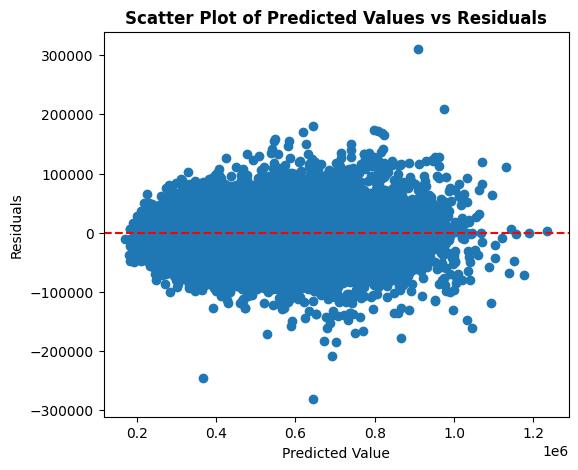

In [76]:
# figure size
plt.figure(figsize=(6,5))

# plot scatterplot
plt.scatter(xgb_pred, residual);

plt.xlabel('Predicted Value')
plt.ylabel('Residuals')
plt.title('Scatter Plot of Predicted Values vs Residuals', fontweight='bold')
plt.axhline(0, color='red', linestyle='--')
plt.show()

From the above residual plot, we can safely conclude that the predicted data is homoscedastic with no huge variances in its distribution

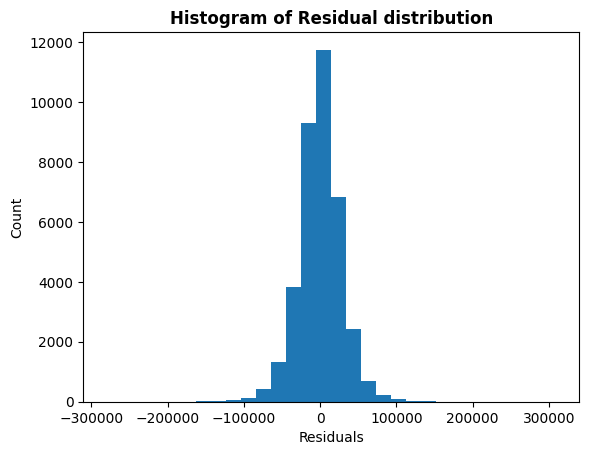

In [77]:
plt.hist(residual, bins=30);

plt.xlabel('Residuals')
plt.ylabel('Count')
plt.title('Histogram of Residual distribution', fontweight='bold')
plt.show()

The above histogram plot justifies our hypothesis that the distribution is approximately normal, as our predictor variables are able to predict the resale price well

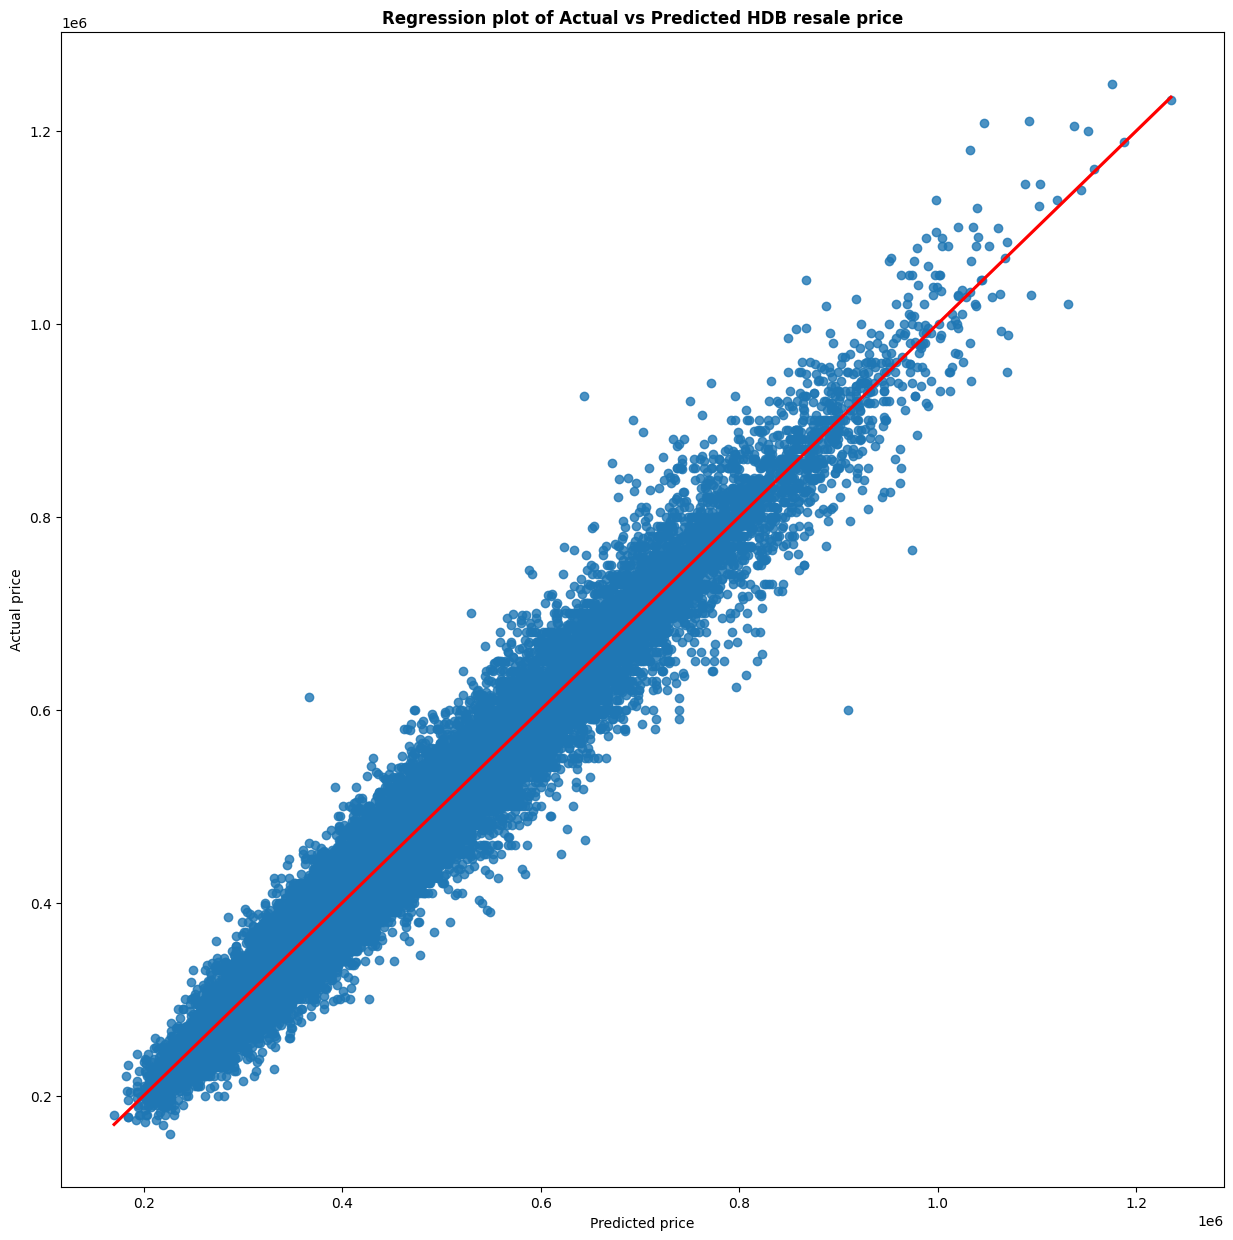

In [78]:
plt.figure(figsize=(15, 15))
sns.regplot(data=X_train, y=y_test, x=xgb_pred, line_kws={'color': 'red'});
plt.xlabel('Predicted price')
plt.ylabel('Actual price')
plt.title('Regression plot of Actual vs Predicted HDB resale price', fontweight='bold')
plt.show()

The relationship between the predicted price against the actual price shows a linear trend where the data points are generally falling along the linear line

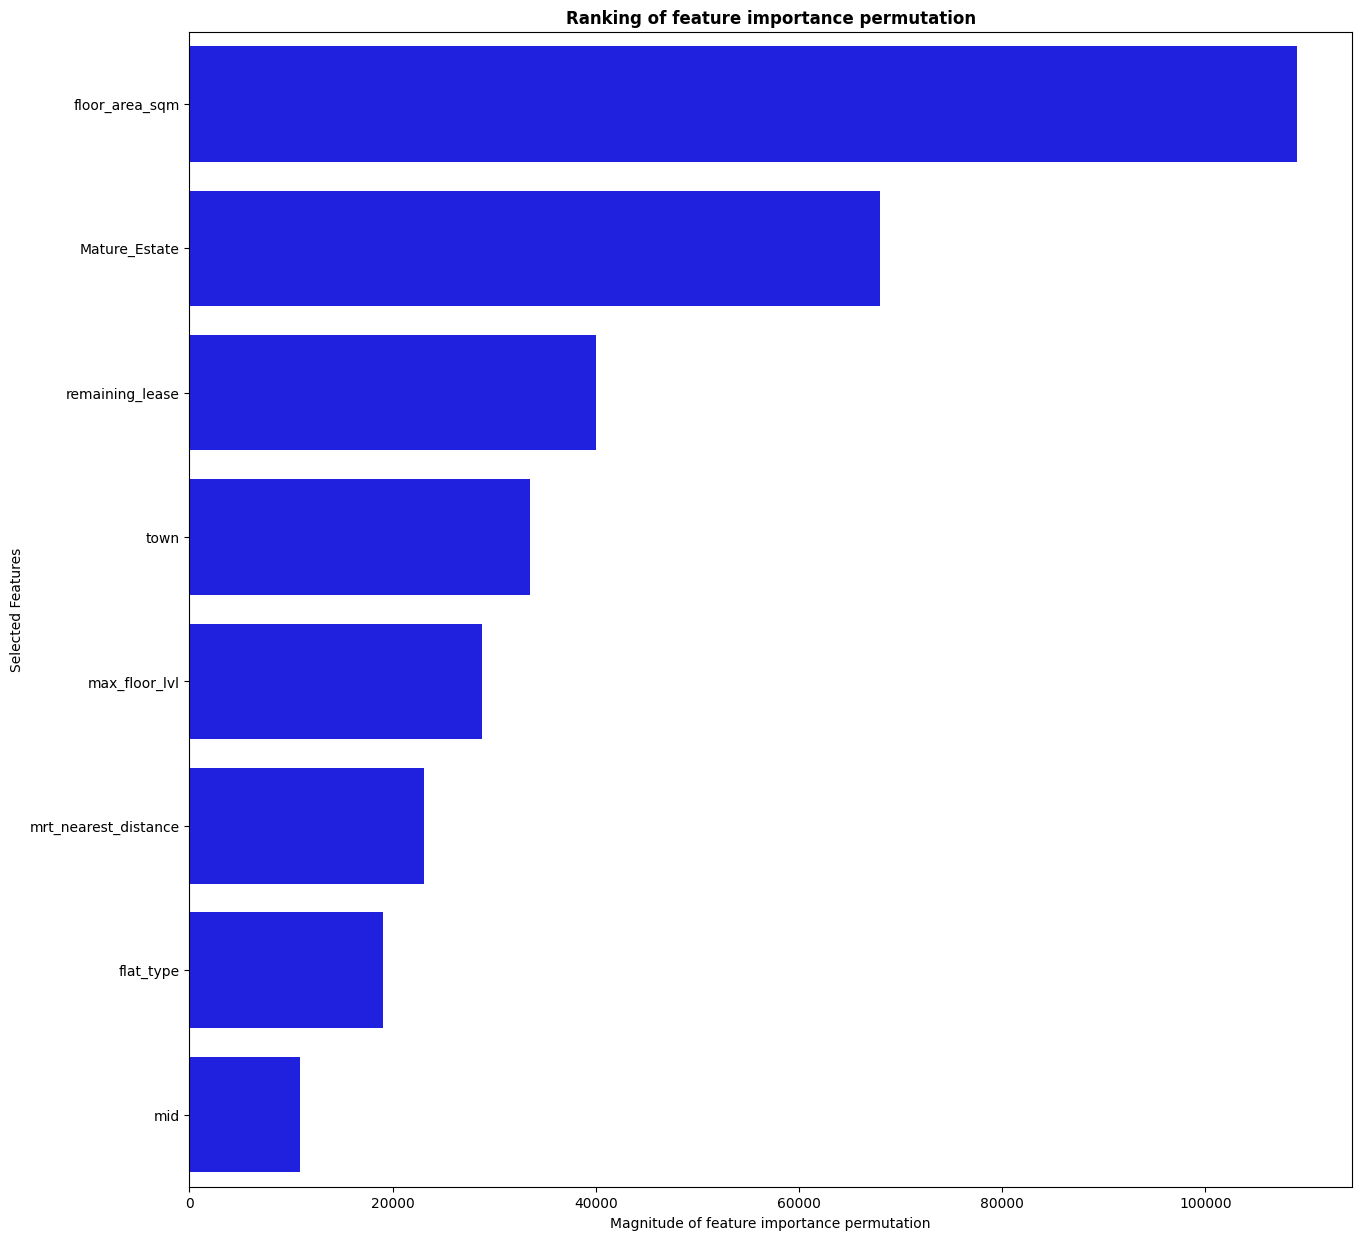

In [79]:
# Create a dataframe of feature importance
plt.figure(figsize=(15, 15))


sns.barplot(data=final_df.head(10), y='feature', x='importance', orient='h', color='blue')
plt.title('Ranking of feature importance permutation', fontweight='bold')
plt.xlabel("Magnitude of feature importance permutation")
plt.ylabel("Selected Features")
plt.show()

The above bar plot shows the importance of how each feature impacts the prediction of resale price upon permutation. According to the plot, we can see that the top 3 variables influencing HDB resale prices are **floor area**, **Mature Estate** and **Number of Remaining Lease years** of the HDB resale flats. This supports our claim that potential HDB buyers will prioritise thease features with greater importance when they are deciding to purchase a resale flat

## Predict test data

The test dataset will be cleaned and pre-processed in the same manner in order to have it organised in the designated format for prediction on unseen data at the Kaggle platform

In [80]:
test = pd.read_csv('../datasets/test.csv')
test.shape

(16737, 77)

In [81]:
null_pct = test.isnull().sum() / len(test) * 100
null_pct.sort_values(ascending=False).head(10)

Hawker_Within_500m       64.258828
Mall_Within_500m         61.492502
Hawker_Within_1km        40.204338
Hawker_Within_2km        19.441955
Mall_Within_1km          16.645755
Mall_Within_2km           1.272630
Mall_Nearest_Distance     0.501882
mrt_name                  0.000000
mrt_nearest_distance      0.000000
hawker_market_stalls      0.000000
dtype: float64

In [82]:
#Impute missing values with mean in order to maintain shape of dataset for kaggle prediction
mall_dist = test['Mall_Nearest_Distance'].mean()
mall_2km = test['Mall_Within_2km'].mean()
test['Mall_Nearest_Distance'] = test['Mall_Nearest_Distance'].fillna(mall_dist)
test['Mall_Within_2km'] = test['Mall_Within_2km'].fillna(mall_2km)

In [83]:
#Impute zeroes to all hawker centers/malls radial threshold distance with missing values similar to train dataset
test['Hawker_Within_500m'] = test['Hawker_Within_500m'].fillna(0.0)
test['Hawker_Within_1km'] = test['Hawker_Within_1km'].fillna(0.0)
test['Hawker_Within_2km'] = test['Hawker_Within_2km'].fillna(0.0)
test['Mall_Within_1km'] = test['Mall_Within_1km'].fillna(0.0)
test['Mall_Within_500m'] = test['Mall_Within_500m'].fillna(0.0)

##### *Feature engineering*

In [84]:
#custom function to map the different towns based on whether they are mature estates or not
town_list = ['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT MERAH', 'BUKIT TIMAH', 'CENTRAL AREA', 'CLEMENTI', 
                 'GEYLANG', 'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'QUEENSTOWN', 'SERANGOON', 
                 'TAMPINES', 'TOA PAYOH']
test['Mature_Estate'] = test['town'].apply(lambda x: 1 if x in town_list else 0)

In [85]:
#Create new features from existing variables to improve the modelling process
#remaining_lease: Number of remaining lease years of the flat
test['remaining_lease'] = test['lease_commence_date'] + 99 - test['Tranc_Year']

In [86]:
#Select final features for modelling
test1 = test[['remaining_lease', 'Mature_Estate', 'max_floor_lvl', 'floor_area_sqm', 'mid', 'town', 
                     'flat_type', 'mrt_nearest_distance']]

In [87]:
#Predict resale prices based on final model
dummy_price = gs_xgb.predict(test1)
dummy_price[:5]

array([379062.28, 516176.1 , 335699.75, 313705.56, 422055.5 ],
      dtype=float32)

In [88]:
dummy_set = pd.DataFrame({'Id': test['id'], 'Predicted': dummy_price})
dummy_set.to_csv('../datasets/xgb_FE_8features.csv', index=False)

Predictions on kaggle scored a RMSE of 28933 with little overfitting

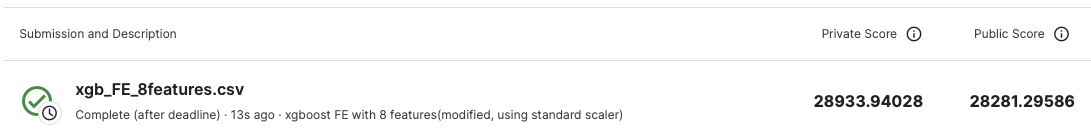

#### *Export model for deployment*

In [42]:
from joblib import dump
dump(gs_xgb, 'HDB_model_final.joblib');